In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# load data

In [91]:
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr_v2"
# )
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr_w_theta"
)


ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)

pairwise_corr_df.loc[pairwise_corr_df.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"
pairwise_corr_df = pairwise_corr_df[~np.isnan(pairwise_corr_df['corrcoef'])]
pairwise_corr_df.reset_index(drop=True, inplace=True)

In [92]:
pairwise_corr_df

,epoch,region,sublayer,ref_uid,target_uid,basepath,corrcoef
0,pre,MEC,Deep,59.0,87.0,Z:\Data\AYAold\AYA7\day19,-0.007657
1,pre,MEC,Deep,59.0,89.0,Z:\Data\AYAold\AYA7\day19,0.002283
2,pre,MEC,Deep,59.0,90.0,Z:\Data\AYAold\AYA7\day19,-0.002704
3,pre,MEC,Deep,59.0,91.0,Z:\Data\AYAold\AYA7\day19,-0.000446
4,pre,MEC,Deep,59.0,92.0,Z:\Data\AYAold\AYA7\day19,-0.009385
...,...,...,...,...,...,...,...
244861,post,PFC,Deep,21.0,38.0,Z:\Data\ORproject\OR18\day2,0.201441
244862,post,PFC,Deep,21.0,39.0,Z:\Data\ORproject\OR18\day2,0.028340
244863,post,PFC,Deep,21.0,40.0,Z:\Data\ORproject\OR18\day2,-0.037148
244864,post,PFC,Deep,21.0,46.0,Z:\Data\ORproject\OR18\day2,0.223751


In [94]:
pairwise_corr_df["region_sublayer"] = pairwise_corr_df["sublayer"] + "_" + pairwise_corr_df["region"]
pairwise_corr_df["r2"] = pairwise_corr_df["corrcoef"] ** 2


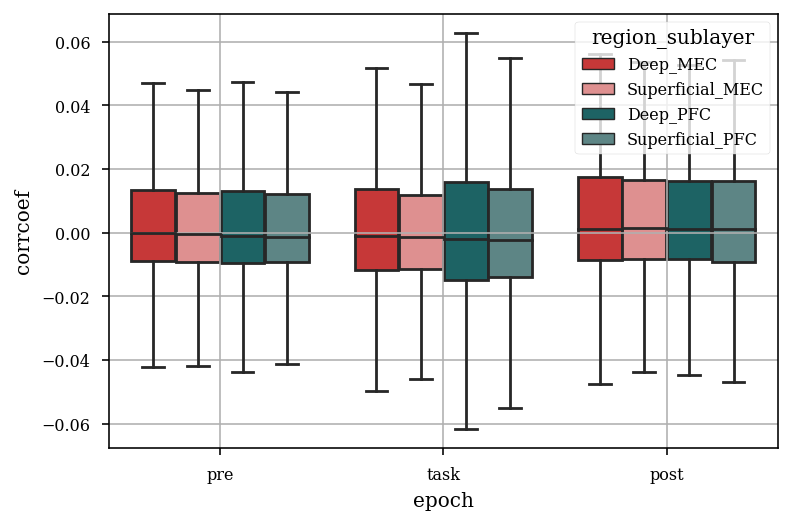

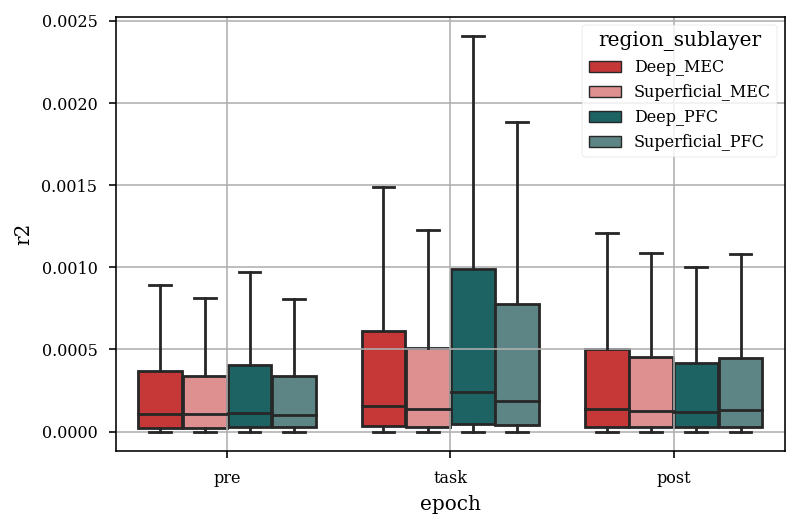

In [95]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))
sns.boxplot(x="epoch", y="corrcoef",hue="region_sublayer",hue_order=group_colors.keys(), data=pairwise_corr_df, showfliers=False)
# sns.stripplot(x="epoch", y="corrcoef",hue="region_sublayer", data=pairwise_corr_df,dodge=True,color='k',alpha=.2)
plt.grid()
plt.show()

sns.boxplot(x="epoch", y="r2",hue="region_sublayer",hue_order=group_colors.keys(), data=pairwise_corr_df, showfliers=False)
# sns.stripplot(x="epoch", y="corrcoef",hue="region_sublayer", data=pairwise_corr_df,dodge=True,color='k',alpha=.2)
plt.grid()
plt.show()

In [96]:
pairwise_corr_df["corrcoef_abs"] = np.abs(pairwise_corr_df["corrcoef"])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pre_Deep_PFC v.s. pre_Superficial_PFC: t-test independent samples with Bonferroni correction, P_val=4.313e-18 stat=8.752e+00
pre_Deep_MEC v.s. pre_Superficial_MEC: t-test independent samples with Bonferroni correction, P_val=6.292e-01 stat=1.006e+00


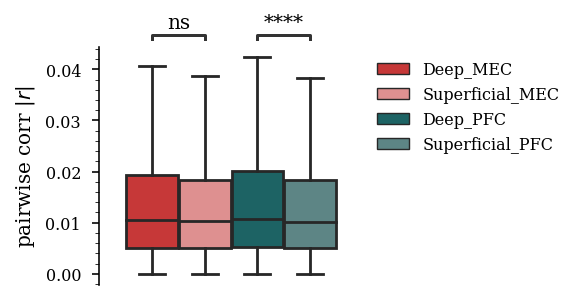

In [98]:
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))
fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)

sns.boxplot(x="epoch", y="corrcoef_abs",hue="region_sublayer", hue_order=group_colors.keys(),
            data=pairwise_corr_df[(pairwise_corr_df.epoch == "pre")],showfliers=False)
sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('pairwise corr $|r|$')
# plt.yscale("log")
plt.legend(
    bbox_to_anchor=(1.8, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
# box_pairs = [
#     (("MEC", "Deep"), ("MEC", "Superficial")),
#     (("PFC", "Deep"), ("PFC", "Superficial")),
# ]
box_pairs = [
    (("pre", "Deep_MEC"), ("pre", "Superficial_MEC")),
    (("pre", "Deep_PFC"), ("pre", "Superficial_PFC")),
]
add_stat_annotation(
    plt.gca(),
    x="epoch",
    y="corrcoef_abs",
    hue="region_sublayer",
    data=pairwise_corr_df[(pairwise_corr_df.epoch == "pre")],
    box_pairs=box_pairs,
    test="t-test_ind",
    text_format="star",
    loc="outside",
    verbose=2,
)
plt.gca().get_xaxis().set_visible(False)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "co_fire_deep_sup_readout_regions.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [99]:
for basepath in pairwise_corr_df.basepath.unique():
    session_idx = pairwise_corr_df.basepath == basepath
    for epoch in pairwise_corr_df[session_idx].epoch.unique():
        epoch_idx = (pairwise_corr_df.epoch == epoch) & (pairwise_corr_df.basepath == basepath)
        pairwise_corr_df.loc[epoch_idx, "session_idx"] = np.arange(sum(epoch_idx))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.294e-17 stat=8.752e+00
MEC_Deep v.s. MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.006e+00
MEC_Superficial v.s. PFC_Deep: t-test independent samples with Bonferroni correction, P_val=8.088e-06 stat=-4.833e+00
MEC_Deep v.s. PFC_Deep: t-test independent samples with Bonferroni correction, P_val=9.625e-06 stat=-4.798e+00
MEC_Superficial v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=3.160e-01 stat=1.938e+00
MEC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=2.139e-03 stat=3.571e+00


(<AxesSubplot:xlabel='region', ylabel='corrcoef_abs'>,
  <statannot.StatResult.StatResult at 0x22c7a6be160>])

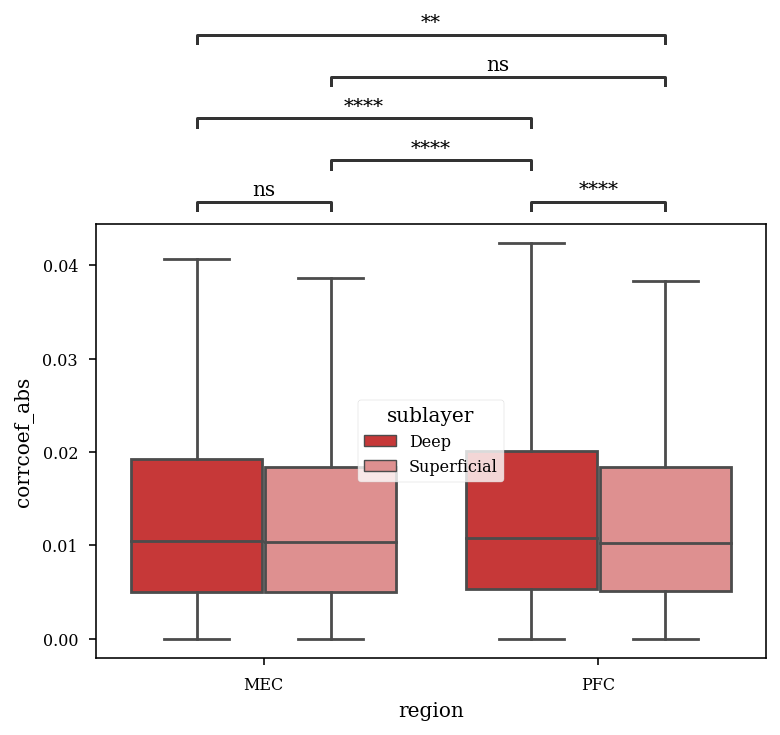

In [100]:
pre_df = pairwise_corr_df[pairwise_corr_df.epoch == "pre"]

sns.boxplot(
    x="region",
    y="corrcoef_abs",
    hue="sublayer",
    data=pre_df,
    showfliers=False,
)
# plt.yscale("log")
box_pairs = [
    (("MEC", "Deep"), ("MEC", "Superficial")),
    (("PFC", "Deep"), ("PFC", "Superficial")),
    (("PFC", "Deep"), ("MEC", "Deep")),
    (("PFC", "Superficial"), ("MEC", "Superficial")),
    (("PFC", "Superficial"), ("MEC", "Deep")),
    (("PFC", "Deep"), ("MEC", "Superficial")),

]
add_stat_annotation(
    plt.gca(),
    x="region",
    y="corrcoef_abs",
    hue="sublayer",
    data=pre_df,
    box_pairs=box_pairs,
    test="t-test_ind",
    text_format="star",
    loc="outside",
    verbose=2,
)

In [101]:
pairwise_corr_df

,epoch,region,sublayer,ref_uid,target_uid,basepath,corrcoef,region_sublayer,r2,corrcoef_abs,session_idx
0,pre,MEC,Deep,59.0,87.0,Z:\Data\AYAold\AYA7\day19,-0.007657,Deep_MEC,5.863039e-05,0.007657,0.0
1,pre,MEC,Deep,59.0,89.0,Z:\Data\AYAold\AYA7\day19,0.002283,Deep_MEC,5.213913e-06,0.002283,1.0
2,pre,MEC,Deep,59.0,90.0,Z:\Data\AYAold\AYA7\day19,-0.002704,Deep_MEC,7.309214e-06,0.002704,2.0
3,pre,MEC,Deep,59.0,91.0,Z:\Data\AYAold\AYA7\day19,-0.000446,Deep_MEC,1.988416e-07,0.000446,3.0
4,pre,MEC,Deep,59.0,92.0,Z:\Data\AYAold\AYA7\day19,-0.009385,Deep_MEC,8.808044e-05,0.009385,4.0
...,...,...,...,...,...,...,...,...,...,...,...
244861,post,PFC,Deep,21.0,38.0,Z:\Data\ORproject\OR18\day2,0.201441,Deep_PFC,4.057856e-02,0.201441,204.0
244862,post,PFC,Deep,21.0,39.0,Z:\Data\ORproject\OR18\day2,0.028340,Deep_PFC,8.031359e-04,0.028340,205.0
244863,post,PFC,Deep,21.0,40.0,Z:\Data\ORproject\OR18\day2,-0.037148,Deep_PFC,1.379966e-03,0.037148,206.0
244864,post,PFC,Deep,21.0,46.0,Z:\Data\ORproject\OR18\day2,0.223751,Deep_PFC,5.006429e-02,0.223751,207.0


In [120]:
df_wide = pd.pivot(
    pairwise_corr_df, index=["basepath","region","sublayer","region_sublayer","session_idx","ref_uid","target_uid"], columns="epoch", values=["corrcoef"]
).reset_index()

df_wide["corrcoef_pre_post"] = (df_wide["corrcoef"]["pre"] - df_wide["corrcoef"]["post"])
df_wide["corrcoef_pre_post_abs"] = np.abs(df_wide["corrcoef_pre_post"])
# df_wide["r2_pre_post"] = (df_wide["corrcoef"]["pre"]**2 - df_wide["corrcoef"]["post"]**2)
# df_wide["r2_pre_post"] = (df_wide["corrcoef"]["pre"]**2 - df_wide["corrcoef"]["post"]**2) / (df_wide["corrcoef"]["pre"]**2 + df_wide["corrcoef"]["post"]**2)
df_wide["r2_pre_post"] = (df_wide["corrcoef"]["pre"]**2 - df_wide["corrcoef"]["post"]**2)
df_wide

basepath region sublayer region_sublayer  \
epoch                                                                 
0         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
1         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
2         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
3         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
4         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
...                             ...    ...      ...             ...   
123159  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
123160  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
123161  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
123162  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
123163  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   

       session_idx ref_uid target_uid  corrcoef                      \
epoch                                      post       pre      task   
0              0.0    59.0       87.0  0.021832 -0.007657  0.000217   
1              1.0    59.0       89.0  0.008737  0.002283 -0.009052   
2              2.0    59.0       90.0  0.008583 -0.002704  0.011609   
3              3.0    59.0       91.0 -0.004666 -0.000446 -0.007629   
4              4.0    59.0       92.0  0.006572 -0.009385 -0.020359   
...            ...     ...        ...       ...       ...       ...   
123159       204.0    21.0       38.0  0.201441 -0.012004  0.003816   
123160       205.0    21.0       39.0  0.028340  0.073991 -0.018767   
123161       206.0    21.0       40.0 -0.037148 -0.025310  0.001035   
123162       207.0    21.0       46.0  0.223751 -0.023506  0.012485   
123163       208.0    21.0       49.0 -0.017014  0.023093  0.040270   

       corrcoef_pre_post corrcoef_pre_post_abs r2_pre_post  
epoch                                                       
0              -0.029489              0.029489   -0.000418  
1              -0.006454              0.006454   -0.000071  
2              -0.011287              0.011287   -0.000066  
3               0.004220              0.004220   -0.000022  
4              -0.015957              0.015957    0.000045  
...                  ...                   ...         ...  
123159         -0.213446              0.213446   -0.040434  
123160          0.045652              0.045652    0.004672  
123161          0.011838              0.011838   -0.000739  
123162         -0.247256              0.247256   -0.049512  
123163          0.040107              0.040107    0.000244  

[123164 rows x 13 columns]

In [ ]:
# df_wide['corrcoef'].unstack().plot()
# corrcoef
# sns.lineplot(x='post', y='corrcoef', style='task', data=df_wide.reset_index())
# df_wide.reset_index()
# df_wide.unstack().keys()

In [127]:
df_wide["corrcoef_pre"] = df_wide["corrcoef","pre"]
df_wide["corrcoef_post"] = df_wide["corrcoef","post"]
df_wide["corrcoef_task"] = df_wide["corrcoef","task"]

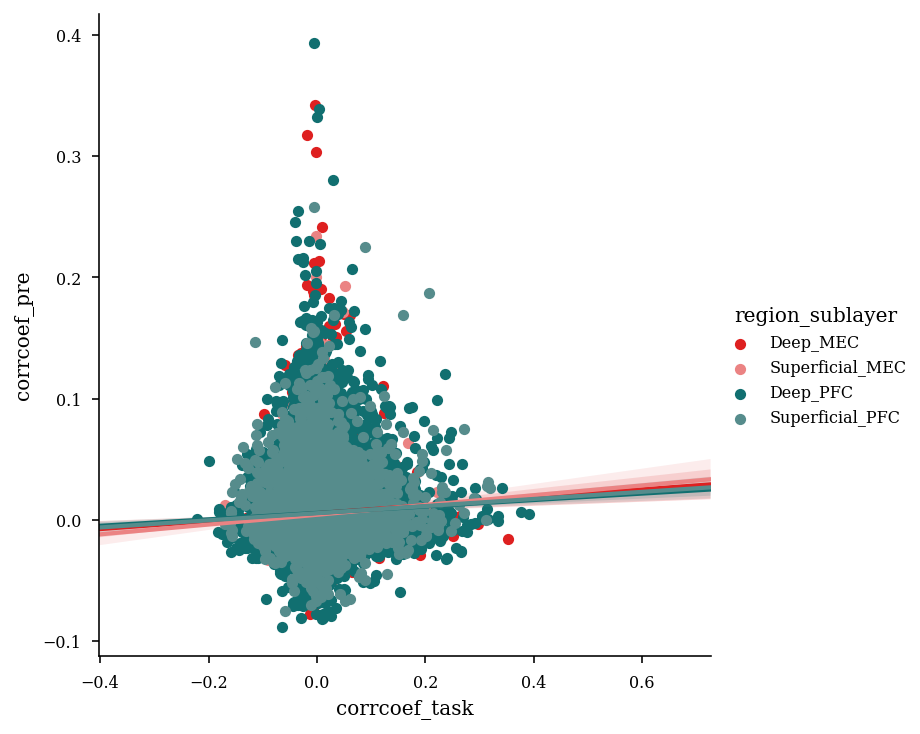

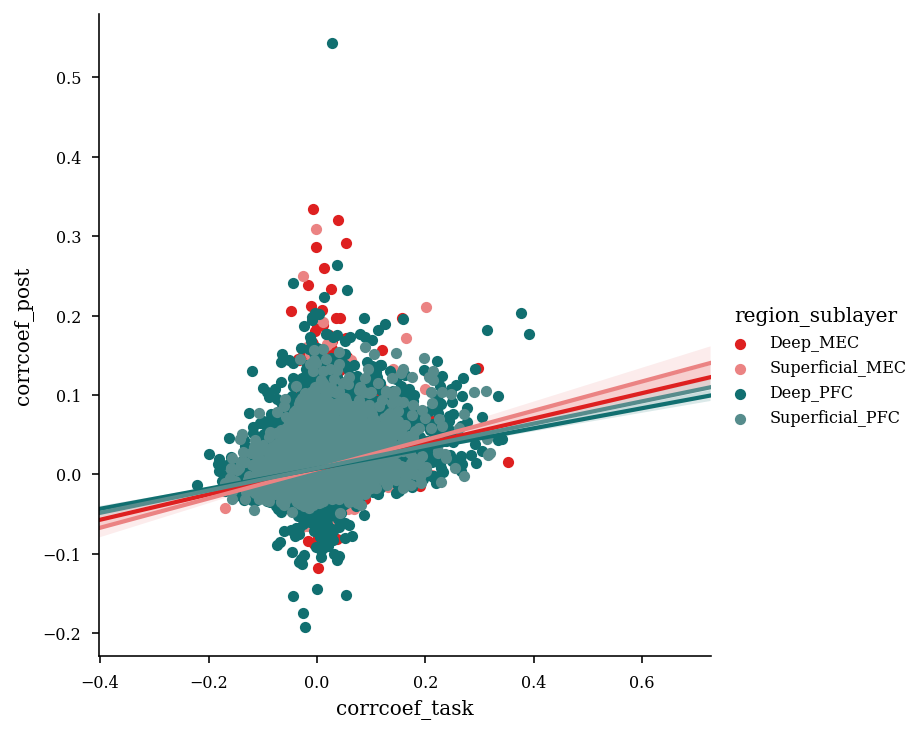

In [160]:
sns.lmplot(
    x="corrcoef_task",
    y="corrcoef_pre",
    hue="region_sublayer",
    data=df_wide,
    truncate=False,
    sharex=True,
    sharey=True,
    scatter_kws={"alpha": 1},
)
plt.show()

sns.lmplot(
    x="corrcoef_task",
    y="corrcoef_post",
    hue="region_sublayer",
    data=df_wide,
    truncate=False,
    sharex=True,
    sharey=True,
    scatter_kws={"alpha": 1},
)
plt.show()
# sns.scatterplot(x="corrcoef_pre",y="corrcoef_post",hue="region_sublayer", data=df_wide)

# plt.xscale("log")
# plt.yscale("log")


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.372e-04 U_stat=2.278e+08
MEC_Deep v.s. MEC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.883e-02 U_stat=4.731e+07


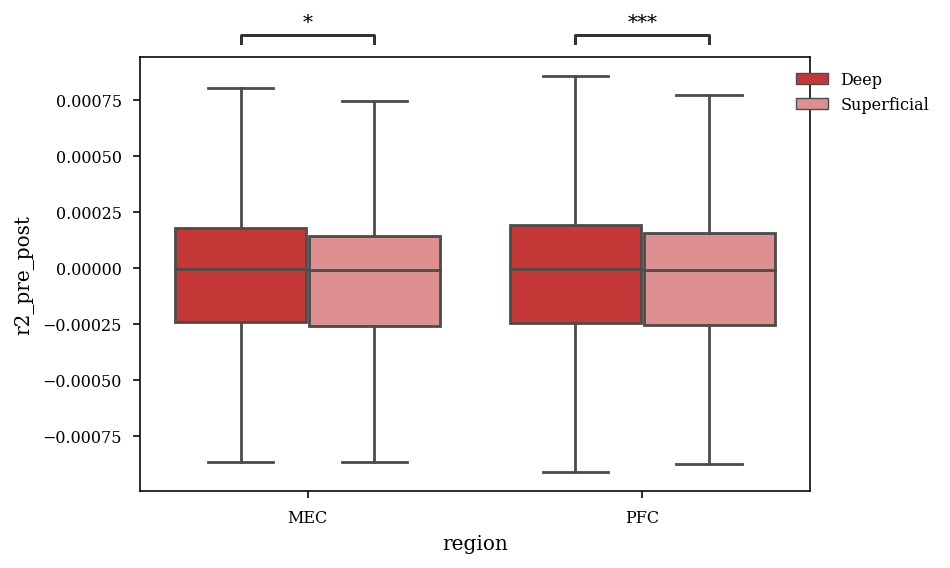

In [103]:
sns.boxplot(
    x="region",
    y="r2_pre_post",
    hue="sublayer",
    data=df_wide,
    showfliers=False,
)

# sns.stripplot(
#     x="region",
#     y="r2_pre_post",
#     hue="sublayer",
#     data=df_wide,
#     dodge=True,
# )
# plt.yscale("log")

box_pairs = [
    (("MEC", "Deep"), ("MEC", "Superficial")),
    (("PFC", "Deep"), ("PFC", "Superficial")),
]
add_stat_annotation(
    plt.gca(),
    x="region",
    y="r2_pre_post",
    hue="sublayer",
    data=df_wide,
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    verbose=2,
)
plt.legend(
    bbox_to_anchor=(1.2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Deep_MEC v.s. Superficial_MEC: t-test independent samples with Bonferroni correction, P_val=1.511e-02 stat=2.672e+00
Deep_PFC v.s. Superficial_PFC: t-test independent samples with Bonferroni correction, P_val=4.256e-09 stat=5.989e+00


(<AxesSubplot:xlabel='region_sublayer', ylabel='corrcoef_pre_post_abs'>,
  <statannot.StatResult.StatResult at 0x22c8bd7f2b0>])

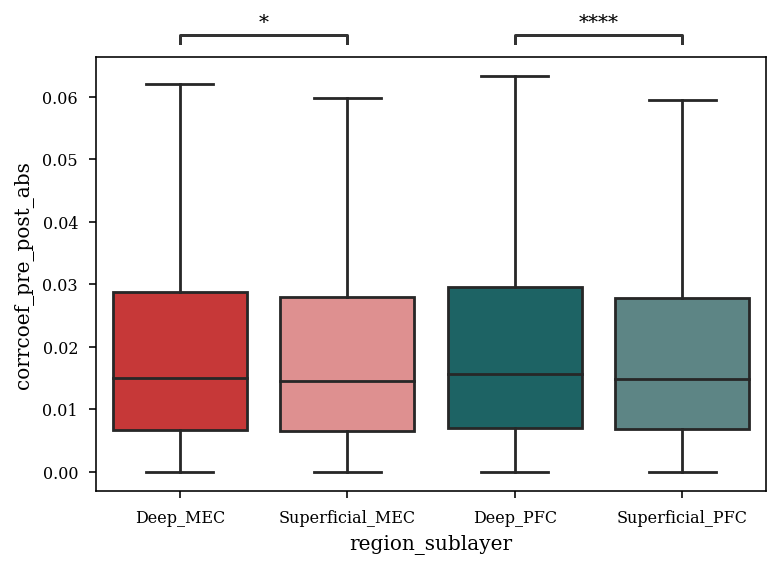

In [104]:

# df_wide["corrcoef_pre_post"] = (df_wide["corrcoef"]["pre"] - df_wide["corrcoef"]["post"]) / (df_wide["corrcoef"]["pre"] + df_wide["corrcoef"]["post"])


# df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]

sns.boxplot(x="region_sublayer", y="corrcoef_pre_post_abs", data=df_wide, showfliers=False)
# sns.stripplot(x="region_sublayer", y="corrcoef_pre_post", data=df_wide,dodge=True,color='k',alpha=.2)

box_pairs=[("Deep_MEC", "Superficial_MEC"), ("Deep_PFC", "Superficial_PFC")]
add_stat_annotation(plt.gca(),x="region_sublayer", y="corrcoef_pre_post_abs", data=df_wide,
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)

In [105]:
for basepath in df_wide.basepath.unique():
    df_wide.loc[df_wide.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)
    
df_wide["unique_uid_pair"] = df_wide.ref_uid.astype(str) + "_" + df_wide.target_uid.astype(str)
df_wide["unique_uid_basepath"] = df_wide.ref_uid.astype(str) + "_" + df_wide.basepath

In [106]:
df_wide.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_corr_readout.csv")

In [44]:
np.unique((df_wide[df_wide.basepath == "Z:\Data\AYAold\AYA7\day19"].ref_uid * df_wide[df_wide.basepath == "Z:\Data\AYAold\AYA7\day19"].target_uid).values).shape

(190,)

In [67]:
df_wide.animal_id.unique()

array(['AYA7', 'AYA9', 'EE', 'HMC1', 'ec013', 'ec014', 'Kenji', 'ec016',
       'OR18'], dtype=object)

In [57]:

df_wide

basepath region sublayer region_sublayer  \
epoch                                                                 
0         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
1         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
2         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
3         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
4         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
...                             ...    ...      ...             ...   
280988  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280989  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280990  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280991  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280992  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   

       session_idx ref_uid target_uid  corrcoef                      \
epoch                                      post       pre      task   
0              0.0    57.0       87.0  0.115733  0.071743  0.022085   
1              1.0    57.0       89.0  0.063071  0.026452  0.000278   
2              2.0    57.0       90.0  0.086257  0.049039 -0.005033   
3              3.0    57.0       91.0 -0.000826  0.005640  0.015633   
4              4.0    57.0       92.0  0.048797  0.113637 -0.015339   
...            ...     ...        ...       ...       ...       ...   
280988       298.0    21.0       39.0  0.228201  0.391553 -0.017103   
280989       299.0    21.0       40.0  0.030981  0.134141  0.005404   
280990       300.0    21.0       45.0  0.090695  0.160112  0.031985   
280991       301.0    21.0       46.0  0.217487  0.308370  0.021767   
280992       302.0    21.0       49.0  0.124707  0.275539  0.057264   

       corrcoef_pre_post corrcoef_pre_post_abs r2_pre_post animal_id  \
epoch                                                                  
0              -0.043990              0.043990    0.001935      AYA7   
1              -0.036619              0.036619    0.001341      AYA7   
2              -0.037219              0.037219    0.001385      AYA7   
3               0.006465              0.006465    0.000042      AYA7   
4               0.064840              0.064840    0.004204      AYA7   
...                  ...                   ...         ...       ...   
280988          0.163352              0.163352    0.026684      OR18   
280989          0.103160              0.103160    0.010642      OR18   
280990          0.069417              0.069417    0.004819      OR18   
280991          0.090883              0.090883    0.008260      OR18   
280992          0.150832              0.150832    0.022750      OR18   

       unique_uid_pair               unique_uid_basepath  
epoch                                                     
0            57.0_87.0    57.0_Z:\Data\AYAold\AYA7\day19  
1            57.0_89.0    57.0_Z:\Data\AYAold\AYA7\day19  
2            57.0_90.0    57.0_Z:\Data\AYAold\AYA7\day19  
3            57.0_91.0    57.0_Z:\Data\AYAold\AYA7\day19  
4            57.0_92.0    57.0_Z:\Data\AYAold\AYA7\day19  
...                ...                               ...  
280988       21.0_39.0  21.0_Z:\Data\ORproject\OR18\day2  
280989       21.0_40.0  21.0_Z:\Data\ORproject\OR18\day2  
280990       21.0_45.0  21.0_Z:\Data\ORproject\OR18\day2  
280991       21.0_46.0  21.0_Z:\Data\ORproject\OR18\day2  
280992       21.0_49.0  21.0_Z:\Data\ORproject\OR18\day2  

[280993 rows x 16 columns]

<AxesSubplot:>

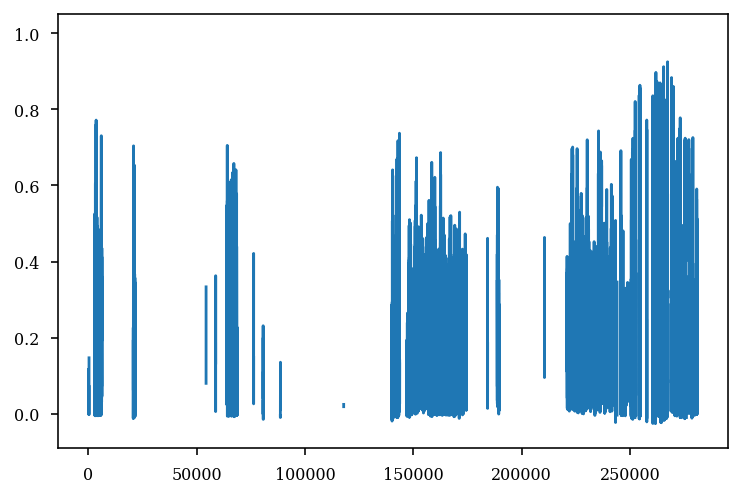

In [56]:
df_wide.corrcoef.post

In [41]:
df_wide[df_wide.basepath == "Z:\Data\AYAold\AYA7\day19"].target_uid.unique().shape

(9,)

In [10]:
from ripple_heterogeneity.readout import readout_explained_var
basepath = r"Z:\Data\HMC1\day8"
results = readout_explained_var.run(
    basepath,  # path to data folder
    reference_region="CA1",  # reference region
    target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],  # regions to compare ref to
    min_cells=5,  # minimum number of cells per region
    restrict_task=False,  # restrict restriction_type to task epochs
    restriction_type="ripples",  # "ripples" or "NREMstate"
    ripple_expand=0.05,  # in seconds, how much to expand ripples
)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 159 last spike(s) of the input spiketrain
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 149 last spike(s) of the input spiketrain
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 92 last spike(s) of the input spiketrain
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 82 last spike(s) of the input spiketrain


In [16]:
results["pairwise_corr_df"][~np.isnan(results["pairwise_corr_df"]["corr"])]

,corr,epoch,region,sublayer,ref_uid,target_uid,basepath
175,0.385963,pre,PFC,Deep,1,184,Z:\Data\HMC1\day8
176,0.347254,pre,PFC,Deep,1,185,Z:\Data\HMC1\day8
177,0.357725,pre,PFC,Deep,1,188,Z:\Data\HMC1\day8
178,0.228768,pre,PFC,Deep,1,194,Z:\Data\HMC1\day8
179,0.352350,pre,PFC,Deep,1,195,Z:\Data\HMC1\day8
...,...,...,...,...,...,...,...
382870,0.166362,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,352,Z:\Data\HMC1\day8
382871,0.142686,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,353,Z:\Data\HMC1\day8
382872,0.043144,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,354,Z:\Data\HMC1\day8
382873,0.227871,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,355,Z:\Data\HMC1\day8


In [3]:
basepath = r"Z:\Data\HMC1\day8"

st,cell_metrics = loading.load_spikes(basepath)

In [4]:
353**2

124609

In [8]:
import itertools

c = np.array(list(itertools.product(cell_metrics.UID.values, repeat=2)))
c[:,0]


array([  1,   1,   1, ..., 356, 356, 356], dtype=uint16)